In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from collections import Counter
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### We dont know true cluster labels. In this case we can use [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for calculating score of clusterization. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [2]:
COLUMNS_TO_DROP = ['year', 'n_citation', 'references', 'authors']
NUM_PARTS = 3
RANDOM_STATE = 42
REDUCED_DIMENSION = 20
NUM_CLUSTERS = 50

def plot_clusters(cluster_ids, cluster_sizes, cluster_names):
    plt.figure(figsize=(18, 7))
    plt.bar(cluster_ids, cluster_sizes)
    plt.xlabel('Cluster id')
    plt.xticks(range(NUM_CLUSTERS))
    plt.title('Cluster sizes')
    ax = plt.gca()
    for bar, word in zip(ax.patches, cluster_names):
        ax.text(bar.get_x() + bar.get_width() / 4, bar.get_y() + bar.get_height()*1.05, word, rotation='vertical', color = 'black', va = 'bottom', fontsize=10) 
    plt.show()

def get_score(X, cluster_labels, sample_size=10000):
    return silhouette_score(X, pipe['kmeans'].labels_, sample_size=sample_size, random_state=RANDOM_STATE)

def get_text_data(file_path):
    data = pd.read_json(file_path, dtype={'title': 'string', 'abstract': 'string'}).drop(COLUMNS_TO_DROP, axis=1)
    data['keywords'] = data['keywords'].apply(lambda row: ' '.join(row)).astype('string')
    data['fos'] = data['fos'].apply(lambda row: ' '.join(row)).astype('string')
    data['venue'] = data['venue'].apply(lambda row: row.get('name_d', '')).astype('string')
    
    data['text'] = data[['keywords', 'fos', 'abstract']].apply(lambda row: ' '.join(row.astype(str)), axis=1).astype('string')
    data.drop(['title', 'abstract', 'venue'], axis=1, inplace=True)
    return data

### Time consuming cell below: 3 parts are loaded, transformed and concatenated together.

In [3]:
# articles = pd.concat(get_text_data(f'data/part_{i+1}_clean.json') for i in range(NUM_PARTS))
# articles.reset_index(drop=True, inplace=True)
# articles.to_json('articles.json')
articles = pd.read_json('articles.json')

articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1084405 entries, 0 to 1084404
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   _id       1084405 non-null  object
 1   keywords  1084405 non-null  object
 2   fos       1084405 non-null  object
 3   text      1084405 non-null  object
dtypes: object(4)
memory usage: 41.4+ MB


In [4]:
articles

,_id,keywords,fos,text
0,53e99784b7602d9701f3e151,handwriting recognition prototypes image segme...,intelligent character recognition pattern reco...,handwriting recognition prototypes image segme...
1,53e99784b7602d9701f3e15d,sequential circuits statistical distributions ...,delay calculation timing failure monte carlo m...,sequential circuits statistical distributions ...
2,53e99784b7602d9701f3f411,internet hypermedia markup languages informati...,xml base world wide web xml framework xml encr...,internet hypermedia markup languages informati...
3,53e99792b7602d9701f5af1a,cognition multi-agent systems ubiquitous compu...,syma computer science symbiotic computing mult...,cognition multi-agent systems ubiquitous compu...
4,53e99792b7602d9701f5b0a5,balanced scorecard,lease computer science balanced scorecard busi...,balanced scorecard lease computer science bala...
...,...,...,...,...
1084400,6052d1c79e795e222b127d58,sketch information retrieval solid modeling ta...,training set 3d model task analysis informatio...,sketch information retrieval solid modeling ta...
1084401,6052fa249e795e222b13be15,hash function random oracle discrete mathemati...,discrete mathematics time space computer scien...,hash function random oracle discrete mathemati...
1084402,6054328e9e795e40330e1fa2,stereopsis computer vision daytime artificial ...,network on computer vision computer science st...,stereopsis computer vision daytime artificial ...
1084403,605828249e795e357b471758,search engine data as a service autonomous sys...,search engine situation awareness computer sci...,search engine data as a service autonomous sys...


### Applying [Porter stemming](https://www.nltk.org/api/nltk.stem.porter.html) to normalize text data

In [5]:
%%time

def normalize(sentence):
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    return ' '.join(porter.stem(word) for word in sentence.split())

articles = articles.parallel_applymap(normalize)

CPU times: total: 30.8 s
Wall time: 7min 38s


In [6]:
articles

,_id,keywords,fos,text
0,53e99784b7602d9701f3e151,handwrit recognit prototyp imag segment comput...,intellig charact recognit pattern recognit com...,handwrit recognit prototyp imag segment comput...
1,53e99784b7602d9701f3e15d,sequenti circuit statist distribut set-up time...,delay calcul time failur mont carlo method seq...,sequenti circuit statist distribut set-up time...
2,53e99784b7602d9701f3f411,internet hypermedia markup languag inform reso...,xml base world wide web xml framework xml encr...,internet hypermedia markup languag inform reso...
3,53e99792b7602d9701f5af1a,cognit multi-ag system ubiquit comput adips-da...,syma comput scienc symbiot comput multi-ag sys...,cognit multi-ag system ubiquit comput adips-da...
4,53e99792b7602d9701f5b0a5,balanc scorecard,leas comput scienc balanc scorecard busi admin...,balanc scorecard leas comput scienc balanc sco...
...,...,...,...,...
1084400,6052d1c79e795e222b127d58,sketch inform retriev solid model task analysi...,train set 3d model task analysi inform retriev...,sketch inform retriev solid model task analysi...
1084401,6052fa249e795e222b13be15,hash function random oracl discret mathemat co...,discret mathemat time space comput scienc rand...,hash function random oracl discret mathemat co...
1084402,6054328e9e795e40330e1fa2,stereopsi comput vision daytim artifici intell...,network on comput vision comput scienc stereop...,stereopsi comput vision daytim artifici intell...
1084403,605828249e795e357b471758,search engin data as a servic autonom system (...,search engin situat awar comput scienc interne...,search engin data as a servic autonom system (...


In [7]:
vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, ngram_range=(1, 2), stop_words='english')
svd = TruncatedSVD(n_components=REDUCED_DIMENSION, random_state=RANDOM_STATE)
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=RANDOM_STATE)

pipe = Pipeline([
    ('tfidf', vectorizer),
    ('svd', svd),
    ('kmeans', kmeans)
])

In [8]:
%%time
pipe.fit(articles.text)

cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

articles_compressed = pipe[:-1].transform(articles.text)
print(articles_compressed.shape)

(1084405, 20)
CPU times: total: 16min 27s
Wall time: 10min 9s


In [9]:
# REDUCED_DIM | NUM_CLUSTERS | score
# 100 50 0.07560141403296246
# 90 50 0.07350460217999018
# 80 50 0.09014818799267464
# 70 50 0.09797929513810197
# 60 50 0.10543775302947447
# 50 50 0.11257597090188336
# 50 40 0.10522467219103467

#ngram=(1, 2)
# 50 50 0.1216299497556675
# 40 50 0.1295353872010128
# 30 50 0.1385145399766233
# 20 50 0.1458188512767084

In [10]:
print('Score:', get_score(articles_compressed, kmeans.labels_))

Score: 0.1458188512767084


### Cluster names based on tfidf score of cluster centers

In [11]:
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_names = terms[order_centroids[:, 0]]

topK = 10
for i in range(NUM_CLUSTERS):
    print(f'Cluster {i}: ', end='')
    print(' '.join(terms[order_centroids[i, :topK]]))

Cluster 0: fuzzi fuzzi set logic set fuzzi logic cluster mathemat data algorithm fuzzi control
Cluster 1: data cluster inform databas algorithm queri secur analysi retriev parallel
Cluster 2: algorithm model mathemat graph optim problem program data method design
Cluster 3: learn recognit data model machin featur algorithm artifici intellig speech
Cluster 4: rout network protocol rout protocol ad hoc hoc ad hoc network wireless mobil
Cluster 5: web servic web servic semant world wide wide web world wide semant web page
Cluster 6: robot mobil mobil robot control motion kinemat plan robot control engin human
Cluster 7: graph mathemat discret mathemat discret combinator vertex network mathemat combinator graph theori tree
Cluster 8: imag segment vision comput vision featur algorithm method artifici object detect
Cluster 9: softwar engin softwar engin softwar develop develop architectur process code engin softwar test
Cluster 10: schedul algorithm resourc optim servic network distribut par

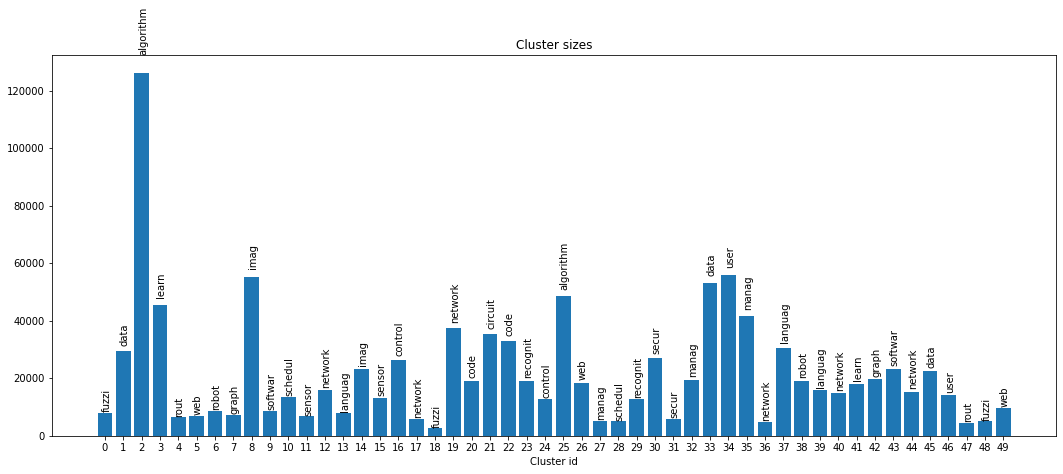

In [12]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names)

### Cluster names based on top words from `keyrowds` + `fos`

In [13]:
cluster_names_counter = []

for cluster_id in range(NUM_CLUSTERS):
    cluster = articles.loc[np.argwhere(kmeans.labels_ == cluster_id).flatten()]
    c = Counter(' '.join((cluster.keywords + ' ' + cluster.fos).values).split())
    print(f'Cluster {cluster_id}: ', end='')
    top_words = c.most_common(topK)
    print(' '.join(pair[0] for pair in top_words))
    cluster_names_counter.append(top_words[0][0])

Cluster 0: fuzzi logic comput system set scienc mathemat data intellig algorithm
Cluster 1: data comput cluster scienc mine algorithm databas analysi system model
Cluster 2: comput scienc mathemat system model algorithm analysi function method theori
Cluster 3: comput model scienc intellig artifici recognit data learn analysi machin
Cluster 4: rout network comput protocol multicast scienc distribut algorithm wireless ad
Cluster 5: web servic semant comput scienc world wide page data model
Cluster 6: robot mobil control comput system engin intellig kinemat artifici motion
Cluster 7: graph mathemat combinator discret comput scienc algorithm theori data vertex
Cluster 8: imag comput vision intellig artifici scienc process algorithm model motion
Cluster 9: softwar engin develop process system comput scienc architectur manag qualiti
Cluster 10: schedul comput system resourc scienc algorithm (computing) distribut network alloc
Cluster 11: network sensor wireless comput distribut scienc key m

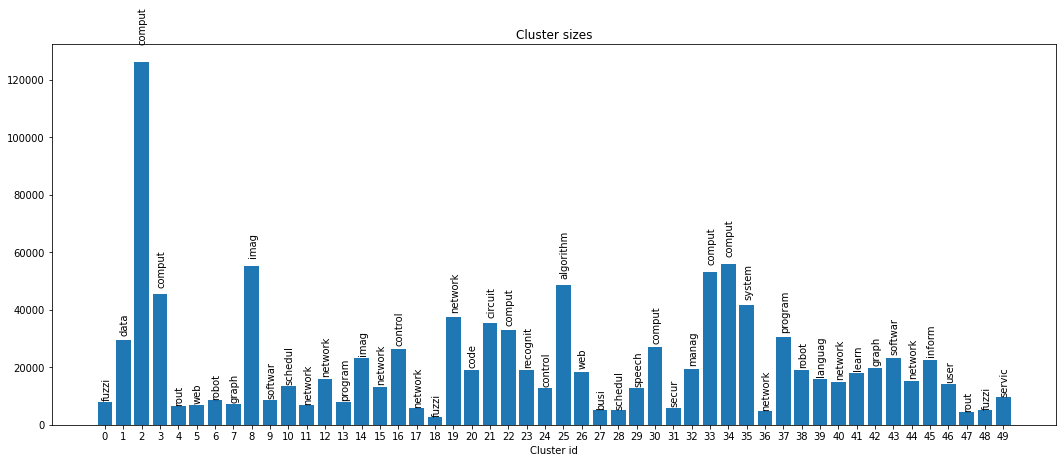

In [14]:
plot_clusters(cluster_ids, cluster_sizes, cluster_names_counter)

### Saving labels

In [15]:
articles['label'] = kmeans.labels_
articles[['_id', 'label']].to_csv('labels.csv', index=False)